## Actividad grupal: Detección de anomalías y técnicas de agrupamiento
### **Nombres:**  XXXX
### **Asignatura:**  Aprendizaje Automático
### **Actividad:** Nro. 3 - mia05_t11_actgrupal

## Librerías utilizadas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

* Se crean las constantes que serán utilizadas para el desarrollo del ejercicio. Por ejemplo, el valor de la semilla aleatoria y otras variables.

In [2]:
semilla_aleatoria = 1234
umbral_categoria = 10
umbral_correlacion = 0.6
pd.options.display.max_columns=21

## 1.- Leer los datos del archivo datasets_20470_26463_creditcardcsvpresent.csv

In [3]:
df_base=pd.read_csv("datasets_20470_26463_creditcardcsvpresent.csv")
display(df_base.head(5))

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


Se realiza posible descripción de las columnas ya que nos puede ayudar a entender los datos.
* **battery_power:** Poder y duración de la batería.

## 2. De las variables numéricas hallar el valor mínimo, el máximo, la mediana y la media.

* Para seleccionar los tipos de datos numéricos se escoge los tipos que los derriben en una lista, luego se utiliza el método describe(), en donde el percentil 50% equivale a la mediana de los datos.

### Selección variables numéricas.
* Se selecciona las variables de tipo numérico mediante un filtrado tipos de datos en el csv.

In [4]:
datos_numericos = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_var_numericas = df_base.select_dtypes(include=datos_numericos).copy()

In [5]:
display(df_var_numericas.describe(include='all'))

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq
count,3.075000e+03,0.0,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,5.026634e+09,NaN,515.026556,9876.399210,0.957398,55.737561,40.022407,0.391870
std,9.870778e+08,NaN,291.906978,10135.331016,2.192391,206.634779,155.968840,1.548479
min,3.160041e+09,NaN,4.011527,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170814e+09,NaN,269.788047,2408.781147,0.000000,0.000000,0.000000,0.000000
50%,5.025578e+09,NaN,502.549575,6698.891856,0.000000,0.000000,0.000000,0.000000
75%,5.889625e+09,NaN,765.272803,14422.568935,0.000000,0.000000,0.000000,0.000000
max,6.665906e+09,NaN,2000.000000,108000.000000,20.000000,998.000000,998.000000,9.000000


## 3. De las variables categóricas, listar las diferentes categorías y hallar la frecuencia de cada una de ellas. 

### Selección variables no numéricas.
* Se selecciona las variables de tipo no numérico mediante un filtrado tipos de datos en el csv.

In [6]:
df_var_no_numericas = df_base[df_base.columns.difference(df_var_numericas.columns)].copy()

* Para el cálculo de frecuencia se las agrupa para cada variable por cada tipo.

In [7]:
for columna in df_var_no_numericas.columns:    
    df_frecuencia_cat=df_var_no_numericas.groupby([columna],as_index=False).size()           
    if len(df_frecuencia_cat)<umbral_categoria:
            print(df_frecuencia_cat)

Is declined
N    3018
Y      57
dtype: int64
isForeignTransaction
N    2369
Y     706
dtype: int64
isFradulent
N    2627
Y     448
dtype: int64
isHighRiskCountry
N    2870
Y     205
dtype: int64


### Para cada categoría se agrega un código que la identifica(variable ficticia).
* Las variables ficticias sirven para representar información cualitativa mediante el uso de estas variables. Estas sirven tantos para modelos de regresión (ficticias aditivas y multiplicativas) y también sirven para medir niveles por categorías.

In [8]:
encoder = LabelEncoder()
df_encoder=df_var_no_numericas.apply(encoder.fit_transform)
df_encoder=df_encoder.add_suffix("_c")
df_categorias_encoder=pd.concat([df_var_no_numericas,df_encoder],axis=1)

## 4.- Tratamiento de missing. 

Antes de realizar cualquier evaluación sobre los datos es importante siempre realizar un tratamiento previo a fin de abordar que hacer con la información faltante. Se citan algunos ejemplos: 
* Si la cantidad de datos faltantes es muy grande se recomienda borrar estas variables.


### Se obtiene las columnas que tienen datos faltantes.

In [9]:
col_total_nulos = df_var_numericas.isnull().sum()
serie_col_nombres = col_total_nulos[col_total_nulos > 0]
display(serie_col_nombres)

Transaction date    3075
dtype: int64

### Eliminar columnas que superan factor máximo datos faltantes.
* Debido a que existe una gran cantidad de datos faltantes se borra estas variables ya que no aportan ningún valor al modelo.

In [10]:
df_var_numericas=df_var_numericas.drop(columns=serie_col_nombres.keys(), axis=1)
total_numericas = df_var_numericas.isna().sum()
serie_col_nombres = total_numericas[total_numericas > 0]
display(serie_col_nombres)

Series([], dtype: int64)

##	5. Hallar todas las correlaciones existentes entre las variables numéricas del conjunto de datos.
* Se utiliza la función de correlación de las variables, en donde un mejor modelo debe considerar aquellas variables más correladas con la variable a estimar y aquellas variables más decorrelladas entre sí. Aclarar que esto dependerá del método de aprendizaje que utilicemos.

In [11]:
mat_corre = df_var_numericas.corr()
display(mat_corre)

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq
Merchant_id,1.000000,0.018223,0.046065,-0.016165,0.088802,0.091621,0.118599
Average Amount/transaction/day,0.018223,1.000000,0.587111,-0.009682,0.060429,0.060284,0.071849
Transaction_amount,0.046065,0.587111,1.000000,0.259309,0.252298,0.259663,0.297623
Total Number of declines/day,-0.016165,-0.009682,0.259309,1.000000,0.094834,0.081138,0.085028
Daily_chargeback_avg_amt,0.088802,0.060429,0.252298,0.094834,1.000000,0.953663,0.884611
6_month_avg_chbk_amt,0.091621,0.060284,0.259663,0.081138,0.953663,1.000000,0.851339
6-month_chbk_freq,0.118599,0.071849,0.297623,0.085028,0.884611,0.851339,1.000000


Analisis de correlaciones existentes entre las variables numéricas del conjunto de datos.

* Como se puede observar existe una alta correlación entre las variables Daily_chargeback_avg_amt, 6_month_avg_chbk_amt y 6-month_chbk_freq; generalmente en los modelos se busca variables correladas con respecto a la variable objetivo y más decorreladas entre sí. Si luego del análisis de las métricas se observa efectos no deseados se puede presumir que la inclusión de estas variables pudo afectar el modelo.

In [12]:
df_cols = mat_corre.stack().reset_index()
df_cols.columns = ['VariableA','VariableB','correlation']
df_corr = df_cols[(df_cols['correlation']>umbral_correlacion)&(df_cols['correlation']!=1)]
display(df_corr)

,VariableA,VariableB,correlation
33,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,0.953663
34,Daily_chargeback_avg_amt,6-month_chbk_freq,0.884611
39,6_month_avg_chbk_amt,Daily_chargeback_avg_amt,0.953663
41,6_month_avg_chbk_amt,6-month_chbk_freq,0.851339
46,6-month_chbk_freq,Daily_chargeback_avg_amt,0.884611
47,6-month_chbk_freq,6_month_avg_chbk_amt,0.851339


**Nota:** La covarianza puede ser un número muy grande. Por tanto, es mejor expresarla de forma normalizada en rangos de valores entre -1 y 1, este proceso de normalización nos ayuda a obtener un coeficiente que se llama coeficiente de correlación y por eso se realizó el análisis anterior utilizando este.

## 5. Determinar el conjunto de modelización y el de validación
* Para determinar el conjunto de modelización se realizara sobre todo el conjunto de variables. Se separa la columna utlizada para predecir si una transacción es fraudulenta(isFradulent).

In [13]:
df_data = pd.concat([df_var_numericas,df_encoder],axis=1)
df_data = df_data.drop(['Merchant_id'], axis=1)
columnas_x=df_data.columns.difference(['isFradulent_c'])
X=df_data[columnas_x]
Y=df_data['isFradulent_c']

* Para este caso se utilizará la normalización **StandardScaler** el cual está representado por la formula z = (x - u) / s.

In [14]:
X_std = StandardScaler()
X_transform= X_std.fit(X).transform(X.astype(float))

* Se segmenta los datos en dos conjuntos uno de entrenamiento con el 80% y de prueba 20% del total de datos respectivamente.

In [15]:
train_x,test_x,train_y,test_y=train_test_split(X_transform,Y,test_size=0.2, random_state = semilla_aleatoria)

## 6. Pasos detección de anomalías con Isolation Forest 

### Parametrización del algoritmo de clasificación

In [16]:
cif = IsolationForest(random_state=semilla_aleatoria).fit(X)
cif.fit(train_x,train_y)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=1234, verbose=0, warm_start=False)

### Predicción del modelo.

In [17]:
predEY_class_cif=cif.predict(test_x)

### Métricas.

In [18]:
df_pred = pd.DataFrame ({'Pred': predEY_class_cif })
display(df_pred['Pred'].value_counts())
display(test_y.value_counts())

 1    499
-1    116
Name: Pred, dtype: int64

0    518
1     97
Name: isFradulent_c, dtype: int64

In [19]:
from sklearn.metrics import f1_score
# mark inliers 1, outliers -1
testy = test_y.copy()
testy[testy == 1] = -1
testy[testy == 0] = 1
score = f1_score(testy, predEY_class_cif, average = "binary")
print('F1 Score: %.3f' % score)

F1 Score: 0.973


In [20]:
display(confusion_matrix(testy,predEY_class_cif))
class_report=classification_report(testy,predEY_class_cif)
print(class_report)

array([[ 93,   4],
       [ 23, 495]], dtype=int64)

              precision    recall  f1-score   support

          -1       0.80      0.96      0.87        97
           1       0.99      0.96      0.97       518

    accuracy                           0.96       615
   macro avg       0.90      0.96      0.92       615
weighted avg       0.96      0.96      0.96       615



### Validación cruzada accuracy score con mínimo 5 folds.

In [21]:
def graficar_accuracy_scores(estimator, train_x, train_y,test_x,test_y,nparts=5,jobs=None,modValue=False):
    kfold = KFold(n_splits=nparts,shuffle=True, random_state=semilla_aleatoria)
    fig,axes = plt.subplots(figsize=(7, 3))
    axes.set_title("F1-score/Nro. Fold")
    axes.set_xlabel("Nro. Fold")
    axes.set_ylabel("F1-score")     
    if modValue:
        trainy = train_y.copy()    
        trainy[train_y == 1] = -1
        trainy[train_y == 0] = 1    
        testy = test_y.copy()
        testy[testy == 1] = -1
        testy[testy == 0] = 1
        train_scores = cross_val_score(estimator, train_x, trainy, cv = kfold, n_jobs=jobs, scoring="f1")
        test_scores = cross_val_score(estimator, test_x, testy, cv = kfold, n_jobs=jobs, scoring="f1")  
    else:
        train_scores = cross_val_score(estimator, train_x, train_y, cv = kfold, n_jobs=jobs, scoring="f1")
        test_scores = cross_val_score(estimator, test_x, test_y, cv = kfold, n_jobs=jobs, scoring="f1")            
    train_sizes = range(1,nparts+1,1)    
    axes.grid()    
    axes.plot(train_sizes, train_scores, 'o-', color="r",label="Datos Entrenamiento")
    axes.plot(train_sizes, test_scores, 'o-', color="g",label="Validacion Cruzada")
    axes.legend(loc="best")
    return train_scores

array([0.9736211 , 0.96670777, 0.97212121, 0.960761  , 0.96526055])

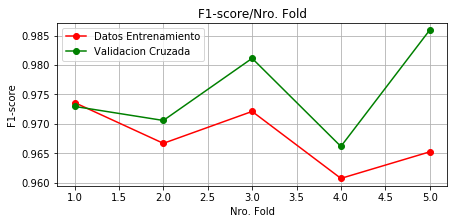

In [22]:
graficar_accuracy_scores(cif,train_x,train_y,test_x,test_y,nparts=5,jobs=2,modValue=True)

### Gráfico Clasificación

Definimos las variables que para realizar la gráfica.

In [38]:
data_inverse = X_std.inverse_transform(test_x)
df_data_x = pd.DataFrame(data=data_inverse,columns=columnas_x)
df_data_cat = pd.DataFrame({'isFradulent':predEY_class_cif})
df_data_grafico = pd.concat([df_data_x,df_data_cat],axis=1)

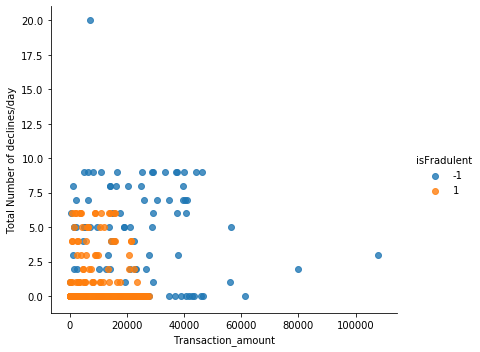

In [39]:
import seaborn as sns
sns.lmplot('Transaction_amount', 'Total Number of declines/day', df_data_grafico, hue='isFradulent', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.show()

## 7. Pasos clasificación método k-means

### Parametrización del algoritmo de clasificación

In [45]:
kmn = KMeans(n_clusters=2, random_state=semilla_aleatoria)
kmn.fit(train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

### Predicción del modelo.

In [41]:
predEY_class_kmn = kmn.predict(test_x)

### Métricas.

In [42]:
display(confusion_matrix(test_y,predEY_class_kmn))
class_report=classification_report(test_y,predEY_class_kmn)
print(class_report)

array([[184,  10,   4,   1,  65, 120, 106,   0,   1,  27],
       [  0,   7,  14,  10,   5,   0,   0,  37,  15,   9],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      0.36      0.52       518
           1       0.41      0.07      0.12        97
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.31       615
   macro avg       0.14      0.04      0.06       615
weighted avg       0.91      0.31      0.46       615



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Validación cruzada accuracy score con mínimo 5 folds.

array([0.34408602, 0.4       , 0.42718447, 0.49438202, 0.41025641])

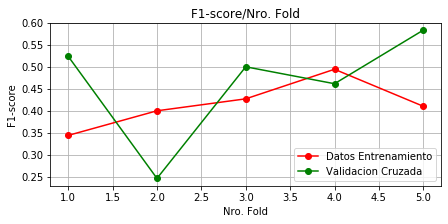

In [46]:
graficar_accuracy_scores(kmn,train_x,train_y,test_x,test_y,nparts=5,jobs=2,modValue=False)

## 13. Comentar los resultados obtenidos en la matriz de confusión de cada uno de los modelos. ¿Cuáles son las ventajas y las desventajas de cada uno de los modelos? ¿Cuál es el mejor modelo? Justifique su respuesta.  

### •	Analizar el rendimiento del modelo de detección de anomalías. ¿Son realmente útiles los modelos creados para el conjunto de datos propuesto?

<h3>Resultados matrices de confusión:</h3>
<ul>
<li> Para las funciones de clasificación la matriz de confusión, cuyos valores son métricas de las estimaciones, en este caso difieren en el valor de ratio de éxito mayor y el valor f1, es por eso que se realizó dos modelos adicionales basados en re-escalar los datos y en la inclusión de multi-clases. Sin embargo, para el modelo de redes neuronales durante el proceso de validación cruzada se puede observar un comportamiento atípico frente a otros modelos de clasificación, ya que los valores de ratio de éxito están bajo en 60%.
</li>
</ul>
<h3>¿Cuál es el mejor modelo?</h3>
El mejor método para clasificar en este conjunto de datos es el basado en SVM ya que en el proceso de validación cruzada sobre los conjuntos de entrenamiento y test respectivamente, mantienen un ratio de éxito sobre el 85%. Adicionalmente, respecto de la cantidad de datos es más óptimo en el tiempo de respuesta y procesamiento. Finalmente, como se observa muy pocas variables están correladas y por eso sus métricas son buenas; incluso sin normalizar los datos previamente.


### •	Para el ejercicio de técnicas de agrupamiento analizar si los clúster creados tienen sentido o no. 

<ul>
<li>Una vez normalizados los datos se observa un mejor comportamiento de las redes de neuronas al realizar la estimación sobre los valores a predecir. Sin embargo, para la SVM la ratio de éxito se redujo luego de la aplicación.</li>
<li>Finalmente para el caso en el que se utilizó un esquema muiti-clase separando las categorías de la variable a predecir como columnas binaras, y en conjunto con la normalización de datos se obtuvo una ratio de éxito análogo al anterior.</li>
</ul>


### •	¿Qué ventajas y desventajas se encuentran en cada uno de los modelos trabajados?

<h3>Vector de soporte:</h3>
<table>
<thead>
<tr>
<th>Ventajas</th>
<th>Desventajas</th>
</tr>
</thead>
<tbody>
<tr><td>* Funcionan bien cuando existe una alta de-correlación entre las clases. Por ejemplo, con data no estructura o semi-estructurada por ejemplo textos, imagines entre otros.</td><td>*Busca el mejor modelo requiere probar diferentes combinaciones de Kernels y parámetros.</td></tr>
<tr><td>* Es más efectiva cuando existen más variables que datos.</td><td>* Se trata de un modelo de caja negra difícil y/o imposible de interpretar.</td></tr>
<tr><td>* Es eficiente respecto del consumo de memoria. Generalmente comparada con redes de neuronas ofrece mejores resultados.</td><td>* En ocasiones puede llevar a un problema del sobreajuste debido a la selección del modelo.</td></tr>    
</tbody>
</table>

<h3>Redes de neuronas:</h3>
<table>
<thead>
<tr>
<th>Ventajas</th>
<th>Desventajas</th>
</tr>
</thead>
<tbody>
<tr><td>* Son adaptables para diferentes campos del aprendizaje automático. Por ejemplo regresión, clasificación, métodos no supervisados entre otros.</td><td>* Mayor tiempo de ejecución. Por tanto computacionalmente costosas.</td></tr>
<tr><td>* Modelos muy precisos. Las redes neuronales aprenden a través de eventos y realizan decisiones relacionándolos.</td><td>* No hay una regla para determinar una mayor estructura para resolver un problema. La estimación de una estructura adecuada se la consigue generalmente a través de métodos prueba y erros y se basan en la experiencia de los datos.</td></tr>
<tr><td>* Son tolerantes a fallos ya que la corrupción de una de sus neuronas (en caso de tener una gran cantidad de ellas), permite que se siga realizando el proceso de estimación.</td><td>* La cantidad de neuronas depende más de una capacidad de procesamiento que del problema en si. Es decir que problemas muy complejos bajo alto coste de infraestructura ya que estas requieren procesadores en paralelo.</td></tr>    
</tbody>
</table>

## Referencias Bibliográficas

* Intellipaat Community. (s. f.). Advantages and disadvantages of neural networks—Intellipaat Community. Recuperado 6 de junio de 2020, de https://intellipaat.com/community/21886/advantages-and-disadvantages-of-neural-networks
* A Beginner’s Guide to Neural Networks in Python | Springboard Blog. (s. f.). Recuperado 3 de junio de 2020, de https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/
* How to build your own Neural Network from scratch in Python. (s. f.). Recuperado 1 de junio de 2020, de https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
* Top 4 advantages and disadvantages of Support Vector Machine or SVM. (s. f.). Recuperado 30 de mayo de 2020, de https://medium.com/@dhiraj8899/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107
